I have used the following methods.

* I used a pretrained <b>ViT</b> architecture for the feature extraction stage [1],
* <b>gelu</b> activation function during the classification stage,
* I used an image processing methods for images <b>(contrast limited adaptive histogram equalization (CLAHE)[2]),</b>
* The project took place using <b>Google TPU</b>,
* Used <b>tf.data</b> for input pipeline,

<br>

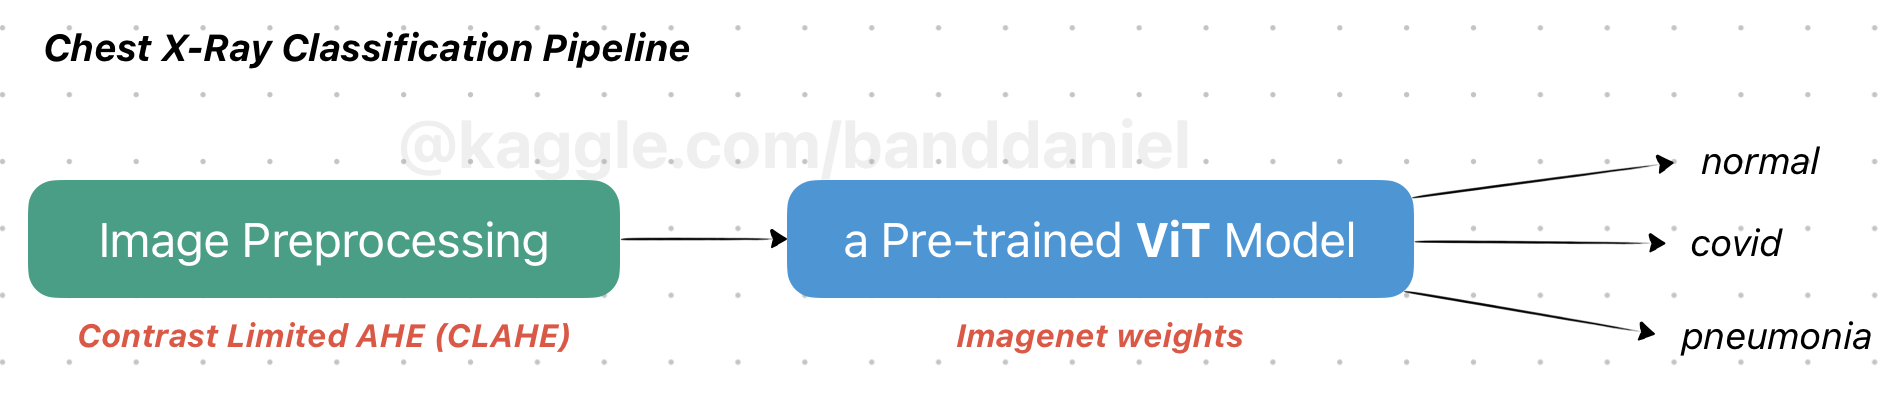



## Image Processing Operation

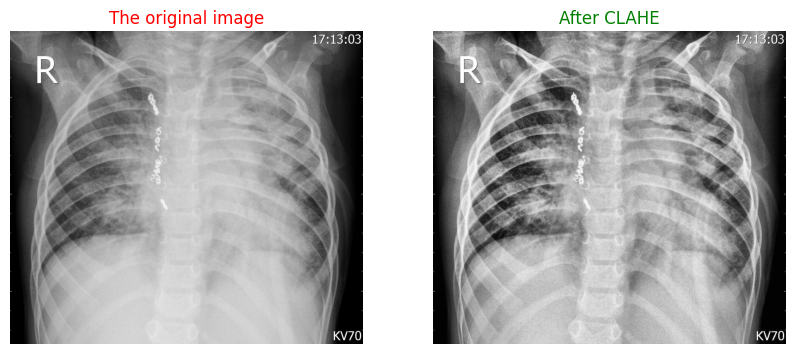


## My Other Projects

* [Smoking Detection w/Online Learning (River)](https://www.kaggle.com/code/banddaniel/smoking-detection-w-online-learning-river)
* [Iris Segmentation U-net w/TPU (Dice Coef: 0.94)](https://www.kaggle.com/code/banddaniel/iris-segmentation-u-net-w-tpu-dice-coef-0-94)
* [Eye Conjunctiva Segmentation with U-Net using TPU (Dice : 0.91, Jaccard : 0.82)](https://github.com/john-fante/my-deep-learning-projects/tree/main/segmentation-projects/eye-conjunctiva-segmentation-main)
* [Retina Vessel Segmentation w/TPU (Test Dice: 0.75)](https://www.kaggle.com/code/banddaniel/retina-vessel-segmentation-w-tpu-test-dice-0-75)



## References
1. https://github.com/faustomorales/vit-keras
2. https://en.wikipedia.org/wiki/Adaptive_histogram_equalization

In [1]:
from IPython.display import clear_output
!pip install vit_keras
clear_output()

In [2]:
# Importing dependencies

import warnings
import logging
import os 
warnings.filterwarnings('ignore')
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from vit_keras import vit


IMG_SIZE = 224, 224
BATCH_SIZE = 32
SEED = 999
AUTO = tf.data.AUTOTUNE
tf.random.set_seed(SEED)

In [3]:
# Connecting TPU and creating strategy and the model

resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)

tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

stg = tf.distribute.experimental.TPUStrategy(resolver)

clear_output()

# <span style="color:#e74c3c;"> Image </span> Processing

(-0.5, 1683.5, 1382.5, -0.5)

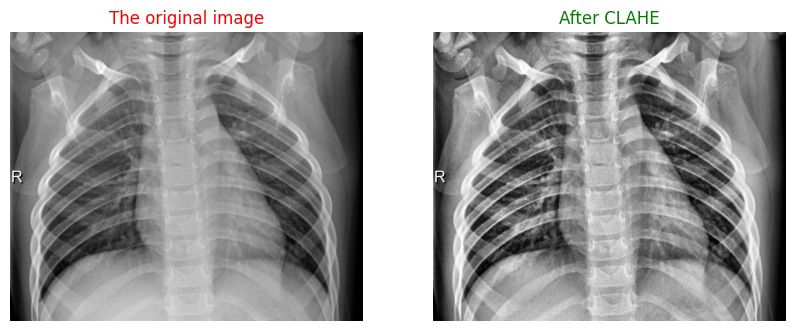

In [4]:
# An example of image operations

normal_image = cv2.imread('/kaggle/input/chest-x-ray-image/Data/train/NORMAL/NORMAL(1005).jpg')
normal_image = cv2.cvtColor(normal_image, cv2.COLOR_BGR2GRAY) #convert to gray

clahe_op = cv2.createCLAHE(clipLimit= 2) # histogram equalization
final_img = clahe_op.apply(normal_image)
    

fig, axs = plt.subplots(1,2, figsize = (10,5), dpi = 100)

axs[0].imshow(normal_image, cmap = 'gray')
axs[0].set_title('The original image', color = 'red')
axs[0].axis('off')

axs[1].imshow(final_img, cmap = 'gray')
axs[1].set_title('After CLAHE', color ='green')
axs[1].axis('off')

In [5]:
# Creating new folders

os.mkdir(os.path.join('/kaggle/working/', 'train'))
os.mkdir(os.path.join('/kaggle/working/train/', 'COVID19'))
os.mkdir(os.path.join('/kaggle/working/train/', 'NORMAL'))
os.mkdir(os.path.join('/kaggle/working/train/', 'PNEUMONIA'))

os.mkdir(os.path.join('/kaggle/working/', 'test'))
os.mkdir(os.path.join('/kaggle/working/test/', 'COVID19'))
os.mkdir(os.path.join('/kaggle/working/test/', 'NORMAL'))
os.mkdir(os.path.join('/kaggle/working/test/', 'PNEUMONIA'))

In [6]:
# A normal image > Gray Image > Histogram Equalization

def image_cvt_histeq(main_path, target_path):
    main_imgs = sorted(os.listdir(main_path))
    for i in main_imgs :

        img = cv2.imread(os.path.join(main_path, i))  
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        clahe_op = cv2.createCLAHE(clipLimit= 2) 
        final_img = clahe_op.apply(img)
        
        cv2.imwrite(os.path.join(target_path, i), final_img)

In [7]:
# Applying the image processing function to all images

image_cvt_histeq('/kaggle/input/chest-x-ray-image/Data/train/COVID19', '/kaggle/working/train/COVID19')
image_cvt_histeq('/kaggle/input/chest-x-ray-image/Data/train/NORMAL', '/kaggle/working/train/NORMAL')
image_cvt_histeq('/kaggle/input/chest-x-ray-image/Data/train/PNEUMONIA', '/kaggle/working/train/PNEUMONIA')

image_cvt_histeq('/kaggle/input/chest-x-ray-image/Data/test/COVID19', '/kaggle/working/test/COVID19')
image_cvt_histeq('/kaggle/input/chest-x-ray-image/Data/test/NORMAL', '/kaggle/working/test/NORMAL')
image_cvt_histeq('/kaggle/input/chest-x-ray-image/Data/test/PNEUMONIA', '/kaggle/working/test/PNEUMONIA')

# <span style="color:#e74c3c;"> Creating </span> Datasets

In [8]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    for i in images:
        full_path.append(os.path.join(path, i))
    return full_path


train_NORMAL = create_images_list("/kaggle/working/train/NORMAL")
train_COVID19 = create_images_list("/kaggle/working/train/COVID19")
train_PNEUMONIA = create_images_list("/kaggle/working/train/PNEUMONIA")


test_NORMAL = create_images_list("/kaggle/working/test/NORMAL")
test_COVID19 = create_images_list("/kaggle/working/test/COVID19")
test_PNEUMONIA = create_images_list("/kaggle/working/test/PNEUMONIA")

# look-up table
classes = {0: 'NORMAL', 1: 'COVID19', 2: 'PNEUMONIA'}

train_data = pd.concat([pd.DataFrame({'img': train_NORMAL, 'label': 0 }),
                        pd.DataFrame({'img': train_COVID19, 'label': 1 }),
                        pd.DataFrame({'img': train_PNEUMONIA, 'label': 2 })], ignore_index = True )


test_data = pd.concat([pd.DataFrame({'img': test_NORMAL, 'label': 0 }),
                       pd.DataFrame({'img': test_COVID19, 'label': 1 }),
                       pd.DataFrame({'img': test_PNEUMONIA, 'label': 2 })], ignore_index = True )


train_data = shuffle(train_data, random_state = SEED).reset_index(drop = True)
test_data = shuffle(test_data, random_state = SEED).reset_index(drop = True)

print("train images -> ", train_data.shape[0])
print("test images -> ", test_data.shape[0])

train_data.head()

train images ->  5144
test images ->  1288


,img,label
0,/kaggle/working/train/COVID19/COVID19(310).jpg,1
1,/kaggle/working/train/PNEUMONIA/PNEUMONIA(445)...,2
2,/kaggle/working/train/PNEUMONIA/PNEUMONIA(1396...,2
3,/kaggle/working/train/PNEUMONIA/PNEUMONIA(2015...,2
4,/kaggle/working/train/NORMAL/NORMAL(805).jpg,0


# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [9]:
# Reading -> Resizing -> Normalization
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, label


# Data augmentation 
def augmentation(image, label):
    img = tf.image.random_brightness(image, 0.1, seed = SEED)
    img = tf.image.random_contrast(img, 0.2, 0.25, seed = SEED)
    
    return img, label

In [10]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((train_data['img'], train_data['label']))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .map(augmentation, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE*20)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((test_data['img'], test_data['label']))
test_dataset = (test_loader
                .map(img_preprocessing, num_parallel_calls = AUTO)
                .batch(BATCH_SIZE)
                .prefetch(AUTO))

# <span style="color:#e74c3c;"> Pre-trained ViT </span> Model

In [11]:
from vit_keras import vit

with stg.scope():
    vit_model = vit.vit_b16(image_size = IMG_SIZE, activation = 'softmax', pretrained = True, include_top = False, pretrained_top = False, classes = 3)

    inp = Input(shape = (*IMG_SIZE, 3))
    vit = vit_model(inp)
    X = Flatten()(vit)
    #X = Dense(256, activation = 'gelu')(X)
    X = Dense(64, activation = 'gelu')(X)
    X = Dense(32, activation = 'gelu')(X)
    out = Dense(3, activation = 'softmax')(X)

    model = Model(inputs = inp, outputs = out)
    model.summary()
    
    model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.0001, weight_decay = 0.001),
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['acc'] )

2023-11-29 18:27:06.126382: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-29 18:27:06.126536: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


347502902/347502902 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 64)                49216     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                            

In [12]:
# Training model

hist = model.fit(train_dataset, epochs = 5, batch_size = BATCH_SIZE)

2023-11-29 18:27:23.612544: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-29 18:27:23.630433: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-29 18:27:23.647917: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-29 18:27:23.665212: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-29 18:27:23.682702: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-29 18:27:23.700480: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-29 18:27:23.717634: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

Epoch 1/5


2023-11-29 18:27:55.522534: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamW/AssignAddVariableOp.
2023-11-29 18:27:59.289467: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-29 18:27:59.292187: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-29 18:27:59.293062: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-29 18:27:59.294441: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


  1/161 [..............................] - ETA: 3:49:55 - loss: 1.0671 - acc: 0.4688

2023-11-29 18:28:50.163287: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-29 18:28:50.163433: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-29 18:28:50.163707: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-29 18:28:50.163818: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-29 18:28:50.163910: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-29 18:28:50.164009: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-29 18:28:50.164111: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

  4/161 [..............................] - ETA: 15s - loss: 0.8845 - acc: 0.5781

2023-11-29 18:28:50.436883: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 54/161 [=========>....................] - ETA: 10s - loss: 0.3499 - acc: 0.8582

2023-11-29 18:28:55.176832: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 58/161 [=========>....................] - ETA: 9s - loss: 0.3343 - acc: 0.8658

2023-11-29 18:28:55.563519: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


108/161 [===================>..........] - ETA: 4s - loss: 0.2676 - acc: 0.8958

2023-11-29 18:29:00.196652: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


161/161 [==============================] - 148s 385ms/step - loss: 0.2254 - acc: 0.9129
Epoch 2/5
151/161 [===========================>..] - ETA: 0s - loss: 0.1204 - acc: 0.9578

2023-11-29 18:30:06.826574: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


161/161 [==============================] - 16s 93ms/step - loss: 0.1173 - acc: 0.9586
Epoch 3/5
  2/161 [..............................] - ETA: 15s - loss: 0.0734 - acc: 0.9844 

2023-11-29 18:30:09.387600: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 97/161 [=================>............] - ETA: 6s - loss: 0.0766 - acc: 0.9707

2023-11-29 18:30:18.306109: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


161/161 [==============================] - 16s 94ms/step - loss: 0.0751 - acc: 0.9718
Epoch 4/5
 70/161 [============>.................] - ETA: 8s - loss: 0.0787 - acc: 0.9714

2023-11-29 18:30:31.881733: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


161/161 [==============================] - 15s 93ms/step - loss: 0.0685 - acc: 0.9769
Epoch 5/5
161/161 [==============================] - 16s 93ms/step - loss: 0.0660 - acc: 0.9778


# <span style="color:#e74c3c;"> Training</span> Results

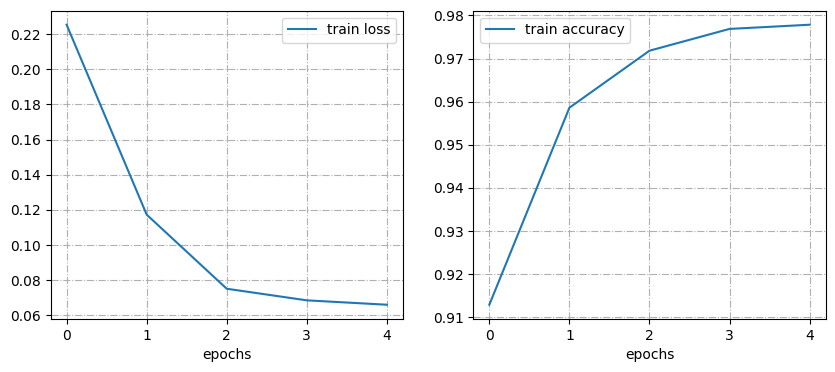

In [13]:
fig, axs = plt.subplots(1,2, figsize = (10, 4), dpi = 100)

axs[0].grid(linestyle = 'dashdot')
axs[0].plot(hist.history['loss'])
axs[0].set_xlabel('epochs', fontsize = 10)
axs[0].legend(['train loss'], fontsize = 10)


axs[1].grid(linestyle = 'dashdot')
axs[1].plot(hist.history['acc'])
axs[1].set_xlabel('epochs', fontsize = 10)
axs[1].legend(['train accuracy'], fontsize = 10)

# <span style="color:#e74c3c;"> Test </span> Evaluations

In [14]:
# Test evaluations of ViT model

with stg.scope():
    print('ViT model results')
    print('--'*50)
    test_eval_vit = model.evaluate(test_dataset)
    print('Test Loss: {0:.3f}'.format(test_eval_vit[0]))
    print('Test Accuracy: {0:.3f} %'.format(test_eval_vit[1]*100))

ViT model results
----------------------------------------------------------------------------------------------------


2023-11-29 18:31:01.259679: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


41/41 [==============================] - 20s 182ms/step - loss: 0.2761 - acc: 0.8983
Test Loss: 0.276
Test Accuracy: 89.829 %


# <span style="color:#e74c3c;"> Test </span> Prediction

In [15]:
# predictions

with stg.scope():
    test_take1 =  test_dataset.take(-1)
    test_take1_ = list(test_take1)
    pred = model.predict(test_take1)
    pred = np.argmax(pred, axis = 1)
    
    
# Predictions and scores

mse = mean_squared_error(test_data['label'], pred)
f1 = f1_score(test_data['label'], pred, average = 'weighted')
acc = accuracy_score(test_data['label'], pred)

print('Mean Squared Error : {0:.5f}'.format(mse))
print('Weighted F1 Score : {0:.3f}'.format(f1))
print('Accuracy Score : {0:.3f} %'.format(acc*100))

41/41 [==============================] - 20s 184ms/step
Mean Squared Error : 0.38354
Weighted F1 Score : 0.902
Accuracy Score : 89.829 %


# <span style="color:#e74c3c;"> Classification </span> Report

In [16]:
clf = classification_report(test_data['label'], pred, target_names = list(classes.values()))
print(clf)

              precision    recall  f1-score   support

      NORMAL       0.72      0.98      0.83       317
     COVID19       1.00      0.91      0.95       116
   PNEUMONIA       0.99      0.86      0.92       855

    accuracy                           0.90      1288
   macro avg       0.90      0.92      0.90      1288
weighted avg       0.92      0.90      0.90      1288



# <span style="color:#e74c3c;"> Confusion </span> Matrix

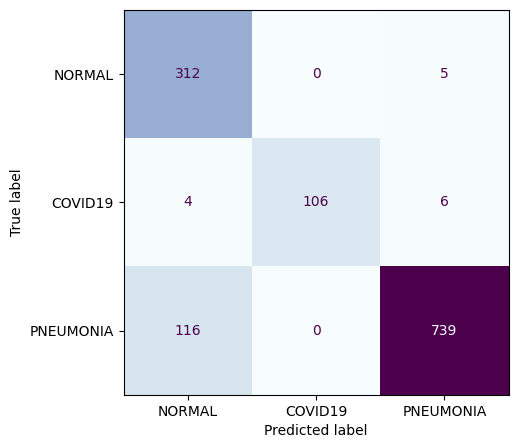

In [17]:
cm = confusion_matrix(test_data['label'], pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(classes.values()))

fig, ax = plt.subplots(figsize=(5,5))
cmd.plot(ax=ax,  cmap = 'BuPu', colorbar = False)

# <span style="color:#e74c3c;"> Test Set </span> Predictions

In [18]:
# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(pred))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (12,12) ,dpi = 150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()
        

        if int(pred[idx[i]]) == label:
            axs[i].imshow(img, cmap = 'gray') 
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img,  cmap = 'gray')
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'red')

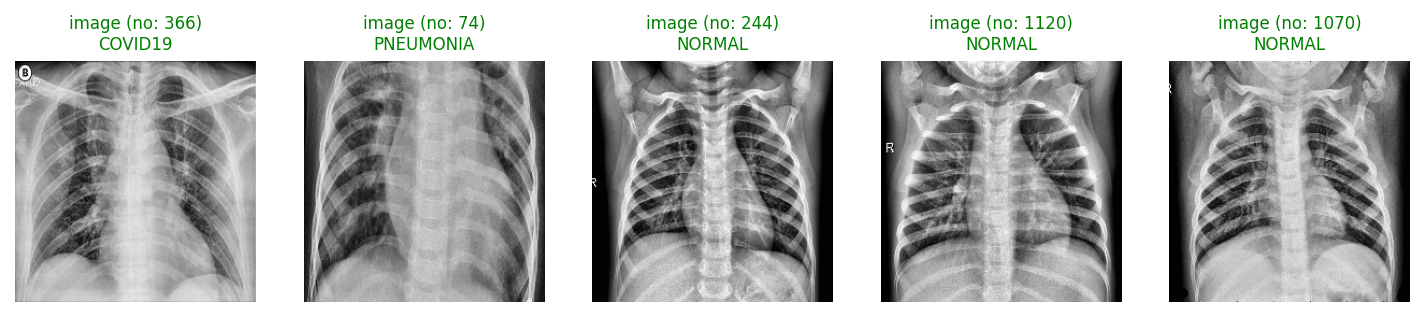

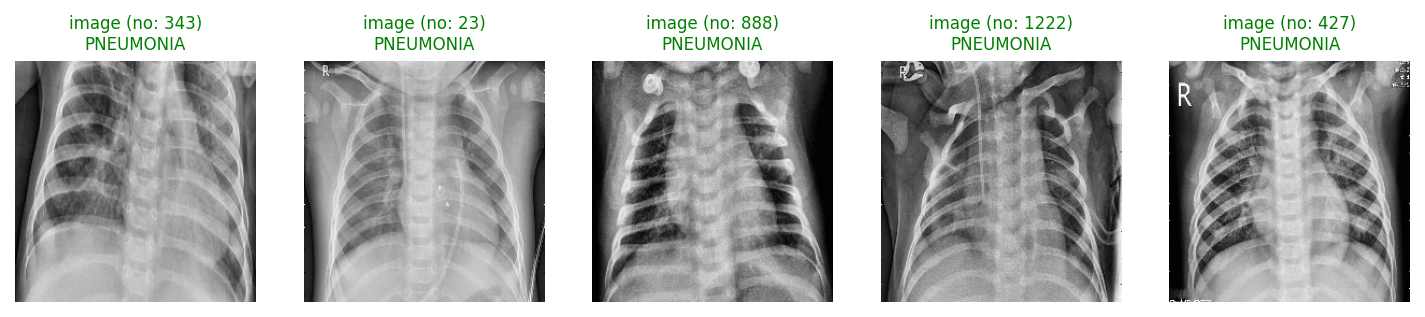

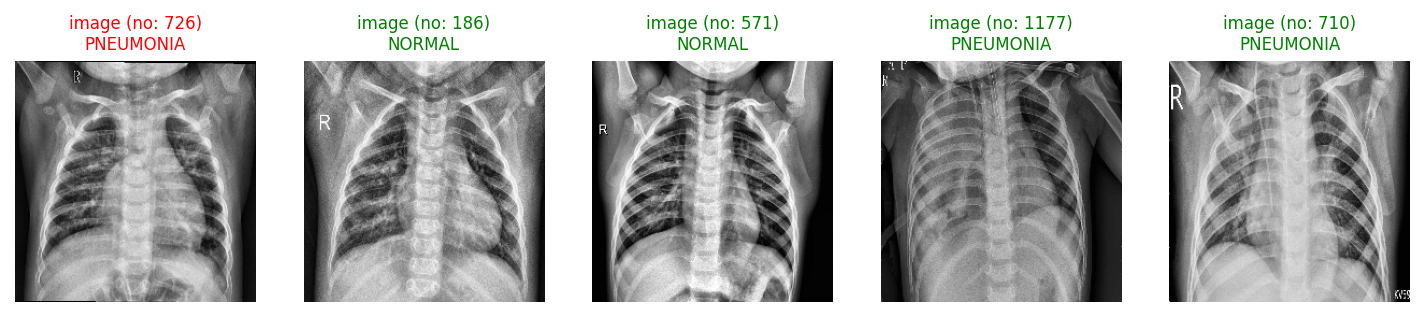

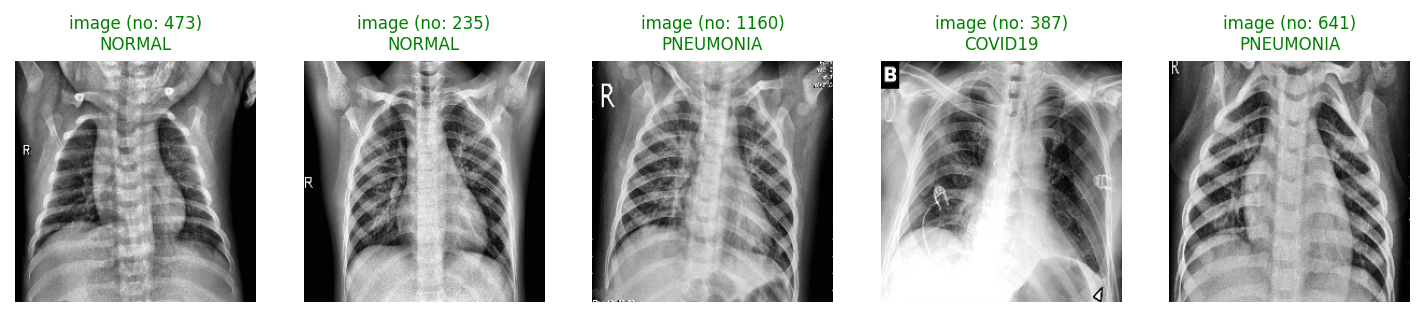

In [19]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction(SEED = 5)
random_test_sample_with_prediction(SEED = 89)
random_test_sample_with_prediction(SEED = 24)
random_test_sample_with_prediction(SEED = 854)